In [1]:
import numpy as np
from scipy.optimize import curve_fit, least_squares
import matplotlib.pyplot as plt
import sncosmo
import pandas as pd
from astropy.table import Table

/home/mauro/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mauro/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mauro/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/mauro/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


Formula for magnitude from flux:

$$m=zp-2.5log_{10}(f)$$

Where $zp$ is the zero point, $f$ the flux and $m$ the magnitude.

Consequently, the formula for flux from magnitude is:

$$\boxed{f = 10^{\frac{-m+zp}{2.5}}}$$

Now, we can calculate $\sigma_{f}$ based on $\sigma_{m}$ using error propagation:

$$\sigma_f = \sqrt{\left(\frac{\delta g}{\delta m}\right)^2 \cdot \sigma_m^2}$$

Where $g(m)$ is the formula for calculating the flux from magnitude. Thus, we have that:

$$\frac{\delta g}{\delta m} = \frac{-ln(10)\cdot10^{\frac{-m+zp}{2.5}}}{2.5}$$

As a result, we have that:

$$\boxed{\sigma_f = \sqrt{\left(\frac{-ln(10)\cdot10^{\frac{-m+zp}{2.5}}}{2.5}\right)^2\cdot\sigma_m^2}}$$


In [2]:
zp = 24.80

In [3]:
def fluxFromMag(m):
    return 10**((-m+zp)/2.5)

def sigmaF(m,sigmaM):
    dgdm = (np.log(10)*10**((zp-m)/2.5)/2.5)
    return (dgdm**2*sigmaM**2)**0.5

def chi2salt2(lc,model):
#     model = sncosmo.Model(source='salt2')
    res, fitted_model = sncosmo.fit_lc(lc, model, ['z', 't0', 'x0', 'x1', 'c'],  bounds={'z':(0.1, 1.3)})
    return res.chisq
    

In [4]:
transients = pd.read_pickle('../DiegoData/lightCurves/transient_lightcurves_clean.pickle')
non_transients = pd.read_pickle('../DiegoData/lightCurves/nontransient_lightcurves_clean.pickle')
catalogue = pd.read_pickle('../DiegoData/transient_catalog.pickle')

In [5]:
# Rename columns to match light curves
catalogue = catalogue.rename(
    columns={'TransientID': 'ID', 'Classification': 'class'})
catalogue.ID = 'TranID' + catalogue.ID.apply(str)
catalogue = catalogue.set_index('ID')

In [6]:
transients = transients.join(catalogue, how='inner')

In [7]:
non_transients['class'] = 'non-transient'

In [8]:
all_objects = transients.append(non_transients)


In [9]:
all_objects['zp'] = zp 
all_objects['zpsys'] = 'ab'
all_objects['band'] = "sdssr"

allCols = list(all_objects.columns)
allCols[2] = 'time'
all_objects.columns = allCols

In [10]:
all_objects['flux'] = fluxFromMag(all_objects['Mag'])
all_objects['fluxerr'] = sigmaF(all_objects['Mag'],all_objects['Magerr'])
all_objects = all_objects.drop(['Mag','Magerr'],axis=1)

In [11]:
SN  = all_objects[all_objects['class'] == 'SN']
NSN = all_objects[all_objects['class'] != 'SN']

In [12]:
SNTable = Table.from_pandas(SN.reset_index())
NSNTable = Table.from_pandas(NSN.reset_index())


In [ ]:
obs_by_name = SNTable.group_by('ID')
chis = []
cont = 1
model = sncosmo.Model(source='salt2')
for key, group in zip(obs_by_name.groups.keys, obs_by_name.groups):
#     print(len(group))
    try:
        chis.append(chi2salt2(group,model))
    except:
        chis.append(-1)
    print('\r {} {} {} '.format(str(len(group)),str(cont*100/len(obs_by_name.groups)),cont),end='')
    cont += 1
#     break

 20 2.7325959661678594 42 

/home/mauro/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:697: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/home/mauro/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:697: RuntimeWarning: invalid value encountered in multiply
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))


 322 5.8555627846454135 90 

/home/mauro/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 19 33.76707872478855 519 

In [47]:
def salt2Df(df):
    ids = df.index.get_level_values('ID').unique()
    ids = np.random.choice(ids,200,replace=False)
    dfToProcess = df[df.index.get_level_values('ID').isin(ids)]
    table = Table.from_pandas(dfToProcess.reset_index())
    
    obs_by_name = table.group_by('ID')
    chis = []
    cont = 1
    model = sncosmo.Model(source='salt2')
    for key, group in zip(obs_by_name.groups.keys, obs_by_name.groups):
    #     print(len(group))
        try:
            chis.append(chi2salt2(group,model))
        except:
            chis.append(-1)
        print('\r {} {} {} '.format(str(len(group)),str(cont*100/len(obs_by_name.groups)),cont),end='')
        cont += 1
        if(cont==200):
            return chis
    

In [48]:
chisSN = salt2Df(SN)

 8 4.0 8 

/home/mauro/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:697: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/home/mauro/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:697: RuntimeWarning: invalid value encountered in multiply
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))


 21 13.5 27 

/home/mauro/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 4 99.5 199 

In [50]:
chisNSN = salt2Df(NSN)

 395 13.0 26 

/home/mauro/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:697: RuntimeWarning: overflow encountered in power
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/home/mauro/anaconda3/lib/python3.6/site-packages/sncosmo/models.py:697: RuntimeWarning: invalid value encountered in multiply
  10. ** (-0.4 * self._colorlaw(wave) * self._parameters[2]))
/home/mauro/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 229 99.5 199 

/home/mauro/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


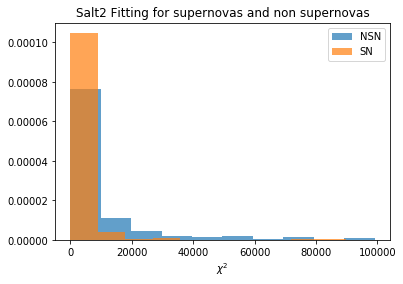

In [52]:
plt.hist(chisNSN,label='NSN',alpha = 0.7,normed = True)
plt.hist(chisSN,label='SN'  ,alpha = 0.7,normed = True)
plt.title('Salt2 Fitting for supernovas and non supernovas')
plt.xlabel(r'$\chi^2$')
plt.legend()

In [ ]:
def mod_gauss(t, a, t0, tf, tr, b):
    return a*((exp(-(t-t0)/tf))/(1+exp(-(t-t0)/tr)))+b
